Dice similarity Coefficients between obtained images and ground truth images :
Maximum :  0.99
Mean :  0.889589430894769

Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels :
Maximum :  0.37
Mean :  0.09706703811841116


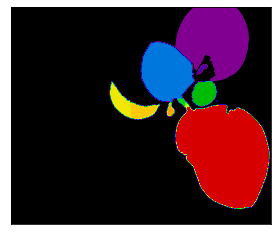

In [72]:
#TOBACCO PLANTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ni
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import glob
import os

def fillHoles(binary_image, binary_copy):
    bits = (0,0)
    cv2.floodFill(binary_copy, None, bits, 255) #fill with black
    binary_copy = cv2.bitwise_not(binary_copy) #find holes within leaves (white pixels in black image)
    FilledHolesImage = cv2.bitwise_or(binary_image, binary_copy) #fill holes within leaves with black color
    return FilledHolesImage


#DICE SIMILARITY COEFFICIENT BETWEEN OBTAINED AND GROUND TRUTH IMAGES
def diceCoeffTobacco(image1, image2):
    # percent of original size
    scale_percent = 100 
    width = int(image1.shape[1] * scale_percent / 100)
    height = int(image1.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    newimage2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA)
    #convert to np arrays
    image1 = np.asarray(image1).astype(np.bool)
    newimage2 = np.asarray(newimage2).astype(np.bool)

    intersection = np.logical_and(image1, newimage2)
    deno = image1.sum() + newimage2.sum()
    dice = 2. * intersection.sum() / deno
    return dice


def individualLeafSegemntation(name, output_folder, TobaccoLabels, coeffs, TobaccoGroundTruthImages):
    i = 0
    for n in name:
        image =  cv2.imread(n)
        # converting to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # find the green color 
        if i<55:
            lower_green = np.array([50,60,60])
            upper_green = np.array([86,255,255])
        else:
            lower_green = np.array([36, 52, 72])
            upper_green = np.array([86, 255, 255])
            
        mask_green = cv2.inRange(hsv, lower_green, upper_green)

        # find any of the three colors(green) in the image
        mask = cv2.bitwise_or(mask_green, mask_green)
        kernel = np.ones((5,5),int)
        mask = cv2.dilate(mask,kernel,iterations = 1)

        # Bitwise-AND mask and original image
        result = cv2.bitwise_and(image, image, mask= mask)

        #pixel values in the mask that are greater than 0 should become the definite/probable foreground
        mask[mask > 0] = cv2.GC_PR_FGD
        mask[mask == 0] = cv2.GC_BGD

        #GRABCUT ALGORITHM IMPLEMENTATION
        size = (1, 65)
        background_arr = np.zeros(size, dtype="float")
        foreground_arr = np.zeros(size, dtype="float")
        
        (mask, background_Model, foreground_Model) = cv2.grabCut(image, mask, None, background_arr, foreground_arr, iterCount=11, mode=cv2.GC_INIT_WITH_MASK)

        #we obtain 4 values, definite/probable background/foreground
        values = (("Definite Background", cv2.GC_BGD), ("Probable Background", cv2.GC_PR_BGD), ("Definite Foreground", cv2.GC_FGD), ("Probable Foreground", cv2.GC_PR_FGD),)

        # set definite and probable background pixels to 0
        # and definite and probable foreground pixels to 1
        outputMask = np.where((mask == cv2.GC_BGD) | (mask == cv2.GC_PR_BGD), 0, 1)
        #scale the mask from the range [0, 1] to [0, 255]
        outputMask = (outputMask * 255).astype("uint8")
        
        #generate final output image
        output = cv2.bitwise_and(image, image, mask=outputMask)

        gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
        ret, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        binary_copy = binary_image.copy() #make copy of binary image to detect holes
        FilledHolesImage = fillHoles(binary_image, binary_copy) #fill holes in leaves using cv2.floodFill()

        #blur = cv2.bilateralFilter(FilledHolesImage,9,75,75)
        #watershed segmentation
        distance_map = ndi.distance_transform_edt(FilledHolesImage)
        local_max = peak_local_max(distance_map, indices=False, min_distance=20, labels=FilledHolesImage)

        # Perform connected component analysis then apply Watershed
        markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]
        labels = watershed(-distance_map, markers, mask=FilledHolesImage)

        plt.imshow(labels, cmap=plt.cm.nipy_spectral)
        plt.xticks([]),plt.yticks([])
        words = n.split('\\')
        file = words[2] + '_Task3.png'
        plt.savefig(output_folder+'/'+file)
        
        TobaccoLabels.append(labels)
        Label_image = cv2.imread(TobaccoGroundTruthImages[i], 0)
        coeffs.append(diceCoeffTobacco(labels, Label_image))
        i=i+1


path_TobaccoImages = "Plant//Tobacco//*_rgb.png"
TobaccoImages = []
for imgName in glob.glob(path_TobaccoImages):
    TobaccoImages.append(imgName) #62 images

output_folder = 'TobaccoOutputImagesTask3'
if os.path.isdir('./'+output_folder) == False: 
    os.mkdir(output_folder)
    
label_images = "Plant//Tobacco//*_label.png"
TobaccoGroundTruthImages = []
for imgName in glob.glob(label_images):
    TobaccoGroundTruthImages.append(imgName) #62 images
    
TobaccoLabels = []
coeffs = []
rows = individualLeafSegemntation(TobaccoImages, output_folder, TobaccoLabels, coeffs, TobaccoGroundTruthImages)

print("Dice similarity Coefficients between obtained images and ground truth images :")
print("Maximum : ", round(max(coeffs), 2))
print("Mean : ", np.mean(coeffs))

#STORE WATERSHED LABELS OF GROUND TRUTH IMAGES
TobaccoGroundImageLabels = []
for n in TobaccoGroundTruthImages:
    plant_image = cv2.imread(n, 0)
    D = ndi.distance_transform_edt(plant_image)
    localMax = peak_local_max(D, indices=False, min_distance=20,labels=plant_image)
    markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=plant_image)
    TobaccoGroundImageLabels.append(labels)

    
#Dice Similarity
def diceCoeff(image1, image2):
    intersection = np.logical_and(image1, image2)
    deno = image1.sum() + image2.sum()
    dice = 2. * intersection.sum() / deno
    return dice
    
coeffs = []
for i in range(0,62):
    coeffs.append(diceCoeff(TobaccoLabels[i], TobaccoGroundImageLabels[i]))
  
print("")
print("Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels :")
print("Maximum : ", round(max(coeffs), 2))
print("Mean : ", np.mean(coeffs))

Dice similarity Coefficients between obtained images and ground truth images of Arabidopsis 2013 :
Maximum :  0.98
Mean :  0.9428471137571572
Dice similarity Coefficients between obtained images and ground truth images of Arabidopsis 2012 :
Maximum :  0.94
Mean :  0.8618899960338768

Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels of Arabidopsis 2013 :
Maximum :  0.52
Mean :  0.12476542307595005

Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels of Arabidopsis 2012:
Maximum :  0.01
Mean :  0.004724721718040213


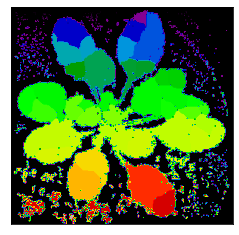

In [76]:
#ARABIDOPSIS PLANTS
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ni
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import glob
import os


#DICE SIMILARITY COEFFICIENT BETWEEN OBTAINED AND GROUND TRUTH IMAGES
def diceCoeffArabidopsis(image1, image2):
    # percent of original size
    scale_percent = 100 
    width = int(image1.shape[1] * scale_percent / 100)
    height = int(image1.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    newimage2 = cv2.resize(image2, dim, interpolation = cv2.INTER_AREA)
    #convert to np arrays
    image1 = np.asarray(image1).astype(np.bool)
    newimage2 = np.asarray(newimage2).astype(np.bool)

    intersection = np.logical_and(image1, newimage2)
    deno = image1.sum() + newimage2.sum()
    dice = 2. * intersection.sum() / deno
    return dice



def individualLeafSegemntation(name, output_folder, ArabidopsisLabels, GroundTruthImages, coeffs):
    i = 0
    for n in name:
        image = cv2.imread(n)
        #sharpening
        kernel = np.array([[0.0, -1.0, 0.0], 
                           [-1.0, 5.0, -1.0],
                           [0.0, -1.0, 0.0]])

        kernel = kernel/(np.sum(kernel) if np.sum(kernel)!=0 else 1)

        img_rst = cv2.filter2D(image,-1,kernel)
        
        frame = img_rst
        image_copy = img_rst.copy()

        #set green component ranges
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2HSV)
        lower_green = np.array([25, 52, 72])
        upper_green = np.array([102, 255, 255])
        #get green component mask
        mask = cv2.inRange(image_copy, lower_green, upper_green)

        m1 = cv2.bitwise_and(frame,frame, mask=mask)
        
        gray = cv2.cvtColor(m1, cv2.COLOR_BGR2GRAY)
        ret, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        #blur = cv2.bilateralFilter(FilledHolesImage,9,75,75)
        #watershed segmentation
        distance_map = ndi.distance_transform_edt(binary_image)
        local_max = peak_local_max(distance_map, indices=False, min_distance=8, labels=binary_image)

        markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]
        labels = watershed(-distance_map, markers, mask=binary_image)

        plt.imshow(labels, cmap=plt.cm.nipy_spectral)
        plt.xticks([]),plt.yticks([])
        #plt.show()
        words = n.split('\\')
        file = words[2] + '_Task3.png'
        plt.savefig(output_folder+'/'+file)
        
        ArabidopsisLabels.append(labels)
        Label_image = cv2.imread(GroundTruthImages[i], 0)
        coeffs.append(diceCoeffArabidopsis(labels, Label_image))
        i=i+1
        
path_Arabidopsis2013Images = "Plant//Ara2013-Canon//*_rgb.png"
path_Arabidopsis2012Images = "Plant//Ara2012//*_rgb.png"
Arabidopsis2013Images = []
for imgName in glob.glob(path_Arabidopsis2013Images):
    Arabidopsis2013Images.append(imgName) 
    
Arabidopsis2012Images = []
for imgName in glob.glob(path_Arabidopsis2012Images):
    Arabidopsis2012Images.append(imgName) 

output_folder_2013 = 'Arabidopsis2013OutputImagesTask3'
if os.path.isdir('./'+output_folder_2013) == False: 
    os.mkdir(output_folder_2013)
    
output_folder_2012 = 'Arabidopsis2012OutputImagesTask3'
if os.path.isdir('./'+output_folder_2012) == False: 
    os.mkdir(output_folder_2012)
    
label_images2013 = "Plant//Ara2013-Canon//*_label.png"
label_images2012 = "Plant//Ara2012//*_label.png"
GroundTruthImages2013 = []
for imgName in glob.glob(label_images2013):
    GroundTruthImages2013.append(imgName) 
    
GroundTruthImages2012 = []
for imgName in glob.glob(label_images2012):
    GroundTruthImages2012.append(imgName) 
    
Arabidopsis2013Labels = []
coeffs2013 = []
rows = individualLeafSegemntation(Arabidopsis2013Images, output_folder_2013, Arabidopsis2013Labels, GroundTruthImages2013, coeffs2013)
Arabidopsis2012Labels = []
coeffs2012 = []
rows = individualLeafSegemntation(Arabidopsis2012Images, output_folder_2012, Arabidopsis2012Labels, GroundTruthImages2012, coeffs2012)

print("Dice similarity Coefficients between obtained images and ground truth images of Arabidopsis 2013 :")
print("Maximum : ", round(max(coeffs2013), 2))
print("Mean : ", np.mean(coeffs2013))

print("Dice similarity Coefficients between obtained images and ground truth images of Arabidopsis 2012 :")
print("Maximum : ", round(max(coeffs2012), 2))
print("Mean : ", np.mean(coeffs2012))
    
#STORE WATERSHED LABELS OF GROUND TRUTH IMAGES
ArabidopsisGroundImages2013Labels = []
for n in GroundTruthImages2013:
    plant_image = cv2.imread(n, 0)
    D = ndi.distance_transform_edt(plant_image)
    localMax = peak_local_max(D, indices=False, min_distance=20,labels=plant_image)
    markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=plant_image)
    ArabidopsisGroundImages2013Labels.append(labels)
    
#STORE WATERSHED LABELS OF GROUND TRUTH IMAGES
ArabidopsisGroundImages2012Labels = []
for n in GroundTruthImages2012:
    plant_image = cv2.imread(n, 0)
    D = ndi.distance_transform_edt(plant_image)
    localMax = peak_local_max(D, indices=False, min_distance=20,labels=plant_image)
    markers = ndi.label(localMax, structure=np.ones((3, 3)))[0]
    labels = watershed(-D, markers, mask=plant_image)
    ArabidopsisGroundImages2012Labels.append(labels)
    
    
#DICE SIMILARITY BETWEEN OBTAINED IMAGE'S WATERSHED LABELS AND GROUND IMAGES WATERSHED LABELS
def diceCoeffArabidopsisLabels(im1, im2):
    intersection = np.logical_and(im1, im2)
    return 2. * intersection.sum() / (im1.sum() + im2.sum())
    
coeffs2013 = []
#print(ArabidopsisImages)
for i in range(0,165):
    coeffs2013.append(diceCoeffArabidopsisLabels(Arabidopsis2013Labels[i], ArabidopsisGroundImages2013Labels[i]))
    
coeffs2012 = []
#print(ArabidopsisImages)
for i in range(0,120):
    coeffs2012.append(diceCoeffArabidopsisLabels(Arabidopsis2012Labels[i], ArabidopsisGroundImages2012Labels[i]))
 
print("")
print("Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels of Arabidopsis 2013 :")
print("Maximum : ", round(max(coeffs2013), 2))
print("Mean : ", np.mean(coeffs2013))

print("")
print("Dice similarity Coefficients between obtained images watershed labels and ground truth images watershed labels of Arabidopsis 2012:")
print("Maximum : ", round(max(coeffs2012), 2))
print("Mean : ", np.mean(coeffs2012))